## Importing Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Set the style for plots
plt.style.use('ggplot')

In [2]:
# Step 1: Loading the Tractsactions and  Customer Demographic Dataset
trans = pd.read_csv('Transactions_Cleaned.csv')
cust = pd.read_csv('CustomerDemographic_Cleaned.csv')

In [3]:
# Display the first few rows of the dataset
trans.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Profit
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,17.87
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,1702.55
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,1544.61
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,817.36
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,1055.82


In [4]:
# Display Total records and columns
print(f"Total records in transactions dataset: {trans.shape[0]}")
print(f"Total columns in transactions dataset: {trans.shape[1]}")

print(f"Total records in customer demographics dataset: {cust.shape[0]}")
print(f"Total columns in customer demographics dataset: {cust.shape[1]}")


Total records in transactions dataset: 19803
Total columns in transactions dataset: 14
Total records in customer demographics dataset: 3912
Total columns in customer demographics dataset: 13


In [5]:
# Merging the transactions and customer demographics datasets using an inner join on 'customer_id'.
merged_trans_cust = pd.merge(trans, cust, on='customer_id', how='inner')


In [6]:
print(f"Total records (rows) in the Merged Dataset: {merged_trans_cust.shape[0]}")
print(f"Total features (columns) in the Merged Dataset: {merged_trans_cust.shape[1]}")

Total records (rows) in the Merged Dataset: 19354
Total features (columns) in the Merged Dataset: 26


In [7]:
# Displaying a summary of the merged dataset to understand column data types, non-null counts, and memory usage.
merged_trans_cust.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19354 entries, 0 to 19353
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_id                       19354 non-null  int64  
 1   product_id                           19354 non-null  int64  
 2   customer_id                          19354 non-null  int64  
 3   transaction_date                     19354 non-null  object 
 4   online_order                         19354 non-null  object 
 5   order_status                         19354 non-null  object 
 6   brand                                19354 non-null  object 
 7   product_line                         19354 non-null  object 
 8   product_class                        19354 non-null  object 
 9   product_size                         19354 non-null  object 
 10  list_price                           19354 non-null  float64
 11  standard_cost               

The data-type of transaction_date column is not in date-time format. Hence the data-type of the column should be changed from object to datetime type.

In [8]:
# Converting the 'transaction_date' column from object to datetime format for proper analysis.
merged_trans_cust['transaction_date'] = pd.to_datetime(merged_trans_cust['transaction_date'], errors='coerce')


## 1. RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach used to segment customers based on their purchasing history. It categorizes customers by how recently they purchased, how often they purchase, and how much they spend. RFM helps identify key customer segments to provide better service and run targeted promotional campaigns.

Recency (R): How recently has a customer purchased? It is measured by the number of days since the last purchase (lower recency indicates more recent activity).

Frequency (F): How often does a customer purchase? It is measured by the total number of purchases (higher frequency indicates more frequent purchasing behavior).

Monetary Value (M): How much does a customer spend? It represents the total amount of money a customer has spent (higher monetary value indicates more significant spending).

RFM analysis helps managers identify valuable segments, such as big spenders who have only purchased once, to determine if they can be encouraged to buy more often, as well as to run effective personalized promotional campaigns.

In [9]:
# Finding the maximum transaction date (i.e., the latest transaction date).
max_trans_date = max(merged_trans_cust['transaction_date']).date()
max_trans_date

datetime.date(2017, 12, 30)

In [10]:
# Taking the latest transaction date as a reference date for comparison
# and finding the number of days between a transaction date and the last transaction date to compute recency.
comparison_date = datetime.strptime(str(max_trans_date), '%Y-%m-%d')


In [11]:
# Create an RFM table that contains all the values for recency, frequency, and monetary data.
rfm_table = merged_trans_cust.groupby(['customer_id']).agg({
    'transaction_date': lambda date: (comparison_date - date.max()).days,  # Recency
    'product_id': 'count',  # Frequency (total number of purchases)
    'Profit': 'sum'  # Monetary value (total profit)
})

# Renaming columns using the inplace parameter
rfm_table.rename(columns={
    'transaction_date': 'recency',
    'product_id': 'frequency',
    'Profit': 'monetary'
}, inplace=True)


In [12]:
rfm_table


,recency,frequency,monetary
customer_id,,,
1,7,11,3018.09
2,128,3,2226.26
3,102,8,3362.81
4,195,2,220.57
5,16,6,2394.94
...,...,...,...
3496,256,4,2045.84
3497,52,3,1648.32
3498,127,6,3147.33


In [13]:
# Dividing the recency, frequency, and monetary values into 4 quartiles (min, 25%, 50%, 75%, and max).
# These values will help calculate the RFM score for each customer and classify them based on their RFM score.

rfm_table['r_quartile'] = pd.qcut(rfm_table['recency'], 4, labels=['4', '3', '2', '1'])
rfm_table['f_quartile'] = pd.qcut(rfm_table['frequency'], 4, labels=['1', '2', '3', '4'])
rfm_table['m_quartile'] = pd.qcut(rfm_table['monetary'], 4, labels=['1', '2', '3', '4'])


In [14]:
# RFM Dataset
rfm_table

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
1,7,11,3018.09,4,4,3
2,128,3,2226.26,1,1,2
3,102,8,3362.81,1,4,3
4,195,2,220.57,1,1,1
5,16,6,2394.94,4,2,2
...,...,...,...,...,...,...
3496,256,4,2045.84,1,1,2
3497,52,3,1648.32,2,1,1
3498,127,6,3147.33,1,2,3


In [15]:
# Calculation of RFM Score.
# Maximum weight is given to recency, then frequency, and finally monetary value.
rfm_table['rfm_score'] = (100 * rfm_table['r_quartile'].astype(int) + 
                           10 * rfm_table['f_quartile'].astype(int) + 
                           rfm_table['m_quartile'].astype(int))


In [16]:
# Assigning a title to a customer based on RFM score.
# 'Platinum' corresponds to the highest range of RFM scores, down to 'Bronze' for the lowest range.
rfm_table['customer_title'] = pd.qcut(rfm_table['rfm_score'], 4, labels=['Bronze', 'Silver', 'Gold', 'Platinum'])


In [17]:
# RFM table dataset

rfm_table

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,customer_title
customer_id,,,,,,,,
1,7,11,3018.09,4,4,3,443,Platinum
2,128,3,2226.26,1,1,2,112,Bronze
3,102,8,3362.81,1,4,3,143,Bronze
4,195,2,220.57,1,1,1,111,Bronze
5,16,6,2394.94,4,2,2,422,Platinum
...,...,...,...,...,...,...,...,...
3496,256,4,2045.84,1,1,2,112,Bronze
3497,52,3,1648.32,2,1,1,211,Bronze
3498,127,6,3147.33,1,2,3,123,Bronze


## Merging RFM Table with Transactions and Customer Demographics Tables

The rfm_table DataFrame is merged with the Transactions and Customer Demographics datasets to gain deeper insights into customer segments along with their transactions. The DataFrames are joined based on the customer_id from both datasets.

In [18]:
# Merging the transactions and customer demographics dataset with the RFM table based on customer_id.
cust_trans_rfm = pd.merge(merged_trans_cust, rfm_table, on='customer_id', how='inner')


In [19]:
# Displaying a summary of the merged dataset to understand column data types, non-null counts, and memory usage.
cust_trans_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19354 entries, 0 to 19353
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19354 non-null  int64         
 1   product_id                           19354 non-null  int64         
 2   customer_id                          19354 non-null  int64         
 3   transaction_date                     19354 non-null  datetime64[ns]
 4   online_order                         19354 non-null  object        
 5   order_status                         19354 non-null  object        
 6   brand                                19354 non-null  object        
 7   product_line                         19354 non-null  object        
 8   product_class                        19354 non-null  object        
 9   product_size                         19354 non-null  object        
 10  list_price

The datatypes of the columns looks fine.

## Creating an Age Group Feature

In [20]:

# Creating an Age_Group column that categorizes ages into decade ranges (e.g., 10, 20, 30, etc.).
cust_trans_rfm['Age_Group'] = cust_trans_rfm['Age'].apply(lambda x: (math.floor(x / 10) + 1) * 10)


## Creating detailed customer titles/tags based on RFM scores.

The customer base is divided into 11 groups:
1. Platinum Customers: Highest RFM scores.
2. Very Loyal: High frequency and monetary value.
3. Becoming Loyal: Increasing frequency and spending.
4. Recent Customers: New customers with recent purchases.
5. Potential Customers: Few purchases but show potential.
6. Late Bloomers: Infrequent purchases but recent spending increase.
7. Losing Customers: Decreased purchase frequency and spending.
8. High-Risk Customers: Low recent activity and spending.
9. Almost Lost Customers: Recent activity but at risk.
10. Evasive Customers: Frequent engagement but low spending.
11. Lost Customers: No engagement in a long time.
These groups help in analyzing customer segments for targeted marketing.


In [21]:
# Function to assign customer titles based on RFM scores
def assign_customer_tag(row):
    if row['r_quartile'] == '4' and row['f_quartile'] == '4' and row['m_quartile'] == '4':
        return 'Platinum Customer'
    elif row['f_quartile'] == '4' and row['m_quartile'] == '4':
        return 'Very Loyal'
    elif row['f_quartile'] == '3' and row['m_quartile'] == '3':
        return 'Becoming Loyal'
    elif row['r_quartile'] == '4' and row['f_quartile'] == '1':
        return 'Recent Customer'
    elif row['f_quartile'] == '2':
        return 'Potential Customer'
    elif row['f_quartile'] == '1' and row['m_quartile'] == '3':
        return 'Late Bloomer'
    elif row['r_quartile'] == '4' and row['f_quartile'] == '1':
        return 'Losing Customer'
    elif row['r_quartile'] == '4' and row['f_quartile'] == '2':
        return 'High Risk Customer'
    elif row['r_quartile'] == '4' and row['f_quartile'] == '3':
        return 'Almost Lost Customer'
    elif row['f_quartile'] == '1' and row['m_quartile'] == '1':
        return 'Evasive Customer'
    else:
        return 'Lost Customer'

# Apply the function to create a new column for customer tags
cust_trans_rfm['detail_cust_title'] = cust_trans_rfm.apply(assign_customer_tag, axis=1)




In [22]:
# Function to get the rank based on customer title
def get_rank(title):
    rank_dict = {
        'Platinum Customer': 1,
        'Very Loyal': 2,
        'Becoming Loyal': 3,
        'Recent Customer': 4,
        'Potential Customer': 5,
        'Late Bloomer': 6,
        'Losing Customer': 7,  # Corrected typo
        'High Risk Customer': 8,
        'Almost Lost Customer': 9,
        'Evasive Customer': 10
    }

    # Return the rank from the dictionary if title is found, otherwise return 11
    return rank_dict.get(title, 11)

# Applying the above functions and creating a new feature rank
cust_trans_rfm['customer_rank'] = cust_trans_rfm['detail_cust_title'].apply(get_rank)


## 2. Exporting to CSV File

After performing a Data Quality Assessment (DQA), data cleaning, and RFM analysis on the dataset, it's time to export the cleaned dataset to a CSV file. This file will be used for further exploratory data analysis (EDA) and will serve as the data source for the customer segmentation dashboard developed in Power BI.

In [23]:
# Exporting the cleaned dataset to a CSV file
cust_trans_rfm.to_csv('Customer_Segmented_Data.csv', index=False)


In [24]:
print('Total Records in Customer Segmented Data : {}'.format(cust_trans_rfm.shape[0]))

Total Records in Customer Segmented Data : 19354


## 3. Data Analysis and Exploration


## 3.1. New Customer vs. Old Customer Age Distributions

Most new and old customers are aged between 40-49. The lowest age groups are under 20 and 80+ for both datasets.

Among the new customers, the most populated age brackets are 20-29 and 60-69, while the majority of old customers are from the 50-69 age bracket.

There is a steep drop in the number of customers in the 30-39 age group among the new customers.

In [25]:
# Loading the New Customer List Data

new_cust = pd.read_csv('NewCustomerList_Cleaned.csv')

In [26]:
new_cust.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Rank,Value,Age,Age Group
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6,1,1.718750,63,70
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11,1,1.718750,51,60
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5,1,1.718750,46,50
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1,4,1.703125,42,50
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,Australia,9,4,1.703125,55,60


In [27]:
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   first_name                           983 non-null    object 
 1   last_name                            954 non-null    object 
 2   gender                               983 non-null    object 
 3   past_3_years_bike_related_purchases  983 non-null    int64  
 4   DOB                                  983 non-null    object 
 5   job_title                            983 non-null    object 
 6   job_industry_category                983 non-null    object 
 7   wealth_segment                       983 non-null    object 
 8   deceased_indicator                   983 non-null    object 
 9   owns_car                             983 non-null    object 
 10  tenure                               983 non-null    int64  
 11  address                         

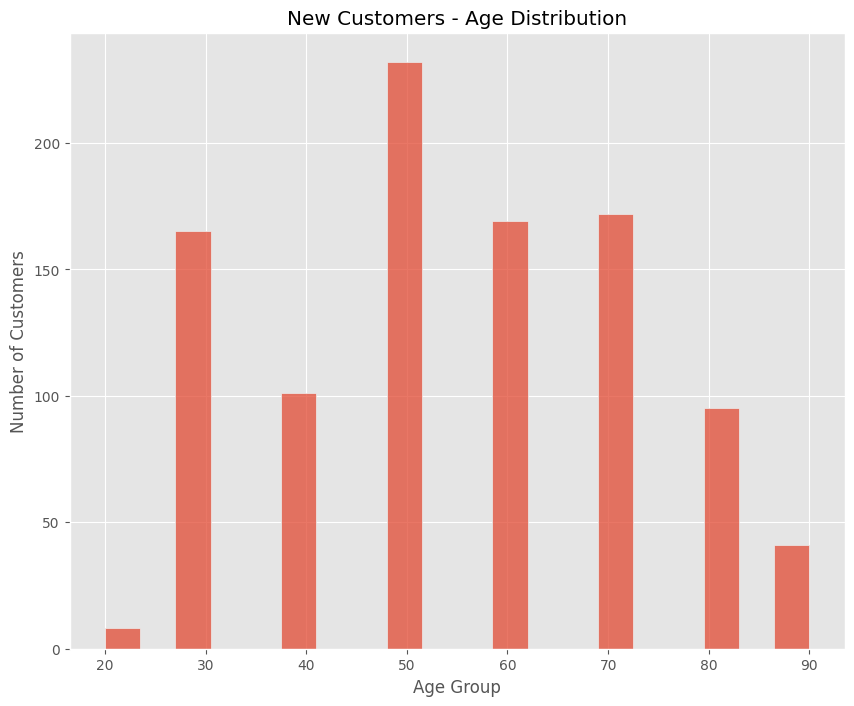

In [28]:
plt.figure(figsize=(10, 8))
# Plot age distribution (using histplot instead of distplot)
sns.histplot(new_cust['Age Group'], kde=False, bins=20)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('New Customers - Age Distribution')

plt.show()

Here 20 = under 20, 30 = 20, 29 age bracket

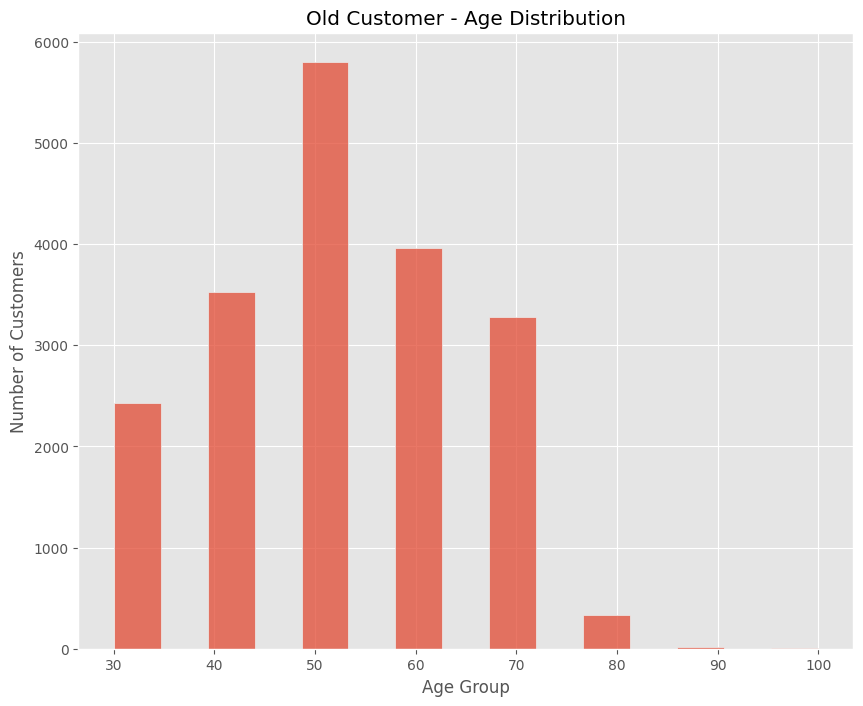

In [29]:
# Plotting a histogram to show the age distribution of old customers
plt.figure(figsize=(10, 8))
sns.histplot(cust_trans_rfm['Age_Group'], kde=False, bins=15)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('Old Customer - Age Distribution')
plt.show()


## 3.2 Bike-related Purchases Over the Last 3 Years by Gender

Over the last three years, approximately 51% of the buyers were women, while 49% were men. Female purchasers were approximately 10,000 more than male purchasers. In terms of gender, the majority of bike sales came from female customers.

In [30]:
# Print the column names of the DataFrame to verify their correctness
print(cust_trans_rfm.columns)

# Remove any leading or trailing spaces from all column names
cust_trans_rfm.columns = cust_trans_rfm.columns.str.strip()


Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'Profit', 'first_name', 'last_name',
       'gender', 'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'Age', 'recency', 'frequency', 'monetary',
       'r_quartile', 'f_quartile', 'm_quartile', 'rfm_score', 'customer_title',
       'Age_Group', 'detail_cust_title', 'customer_rank'],
      dtype='object')


In [31]:
print(cust_trans_rfm.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19354 entries, 0 to 19353
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19354 non-null  int64         
 1   product_id                           19354 non-null  int64         
 2   customer_id                          19354 non-null  int64         
 3   transaction_date                     19354 non-null  datetime64[ns]
 4   online_order                         19354 non-null  object        
 5   order_status                         19354 non-null  object        
 6   brand                                19354 non-null  object        
 7   product_line                         19354 non-null  object        
 8   product_class                        19354 non-null  object        
 9   product_size                         19354 non-null  object        
 10  list_price

In [32]:
cust_bike_purchase_by_gender = cust_trans_rfm.groupby('gender').agg({'past_3_years_bike_related_purchases' : sum}).reset_index()

C:\Users\thang\AppData\Local\Temp\ipykernel_20684\4198234066.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cust_bike_purchase_by_gender = cust_trans_rfm.groupby('gender').agg({'past_3_years_bike_related_purchases' : sum}).reset_index()


In [33]:
total_records = cust_trans_rfm['past_3_years_bike_related_purchases'].count()

In [34]:
cust_bike_purchase_by_gender['Percent_of_total'] = (cust_bike_purchase_by_gender['past_3_years_bike_related_purchases'] / total_records) * 100

In [35]:
cust_bike_purchase_by_gender

,gender,past_3_years_bike_related_purchases,Percent_of_total
0,Female,478488,2472.295133
1,Male,468943,2422.977162


C:\Users\thang\AppData\Local\Temp\ipykernel_20684\3418859648.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y = 'Percent_of_total', data=cust_bike_purchase_by_gender, palette='deep')


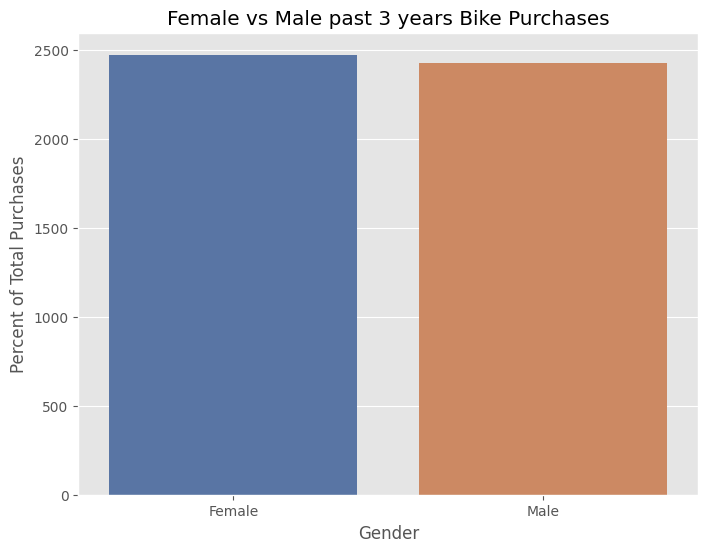

In [36]:
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y = 'Percent_of_total', data=cust_bike_purchase_by_gender, palette='deep')
plt.xlabel('Gender')
plt.ylabel('Percent of Total Purchases')
plt.title('Female vs Male past 3 years Bike Purchases')

plt.show()

## 3.3 Job Industry Customer Distribution

Among the new customers, the highest sales come from those employed in the Manufacturing and Financial Services sectors. Conversely, the smallest portion of sales is attributed to customers in the Agriculture and Telecom sectors, each contributing only 3% of total sales. A similar trend is observed among old customers.

C:\Users\thang\AppData\Local\Temp\ipykernel_20684\1175058695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='job_industry_category', data=new_cust[~(new_cust['job_industry_category'] == 'Missing')],


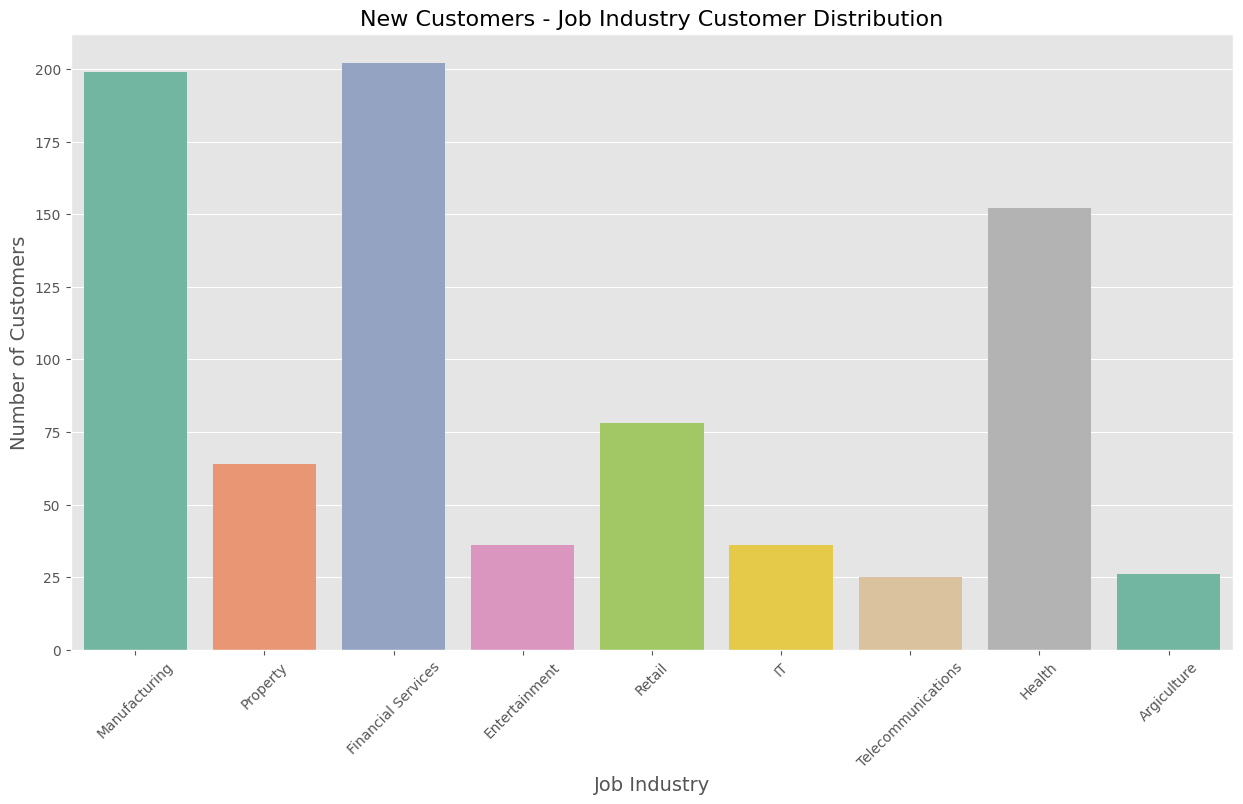

In [37]:

# Set the figure size for the plot
plt.figure(figsize=(15, 8))

# Create a count plot for job industry distribution, excluding 'Missing' entries
sns.countplot(x='job_industry_category', data=new_cust[~(new_cust['job_industry_category'] == 'Missing')],
               palette='Set2')  # Using Set2 color palette for better visual appeal

plt.xlabel('Job Industry', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.title('New Customers - Job Industry Customer Distribution', fontsize=16)
plt.xticks(rotation=45)

plt.show()

C:\Users\thang\AppData\Local\Temp\ipykernel_20684\344377113.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='job_industry_category',


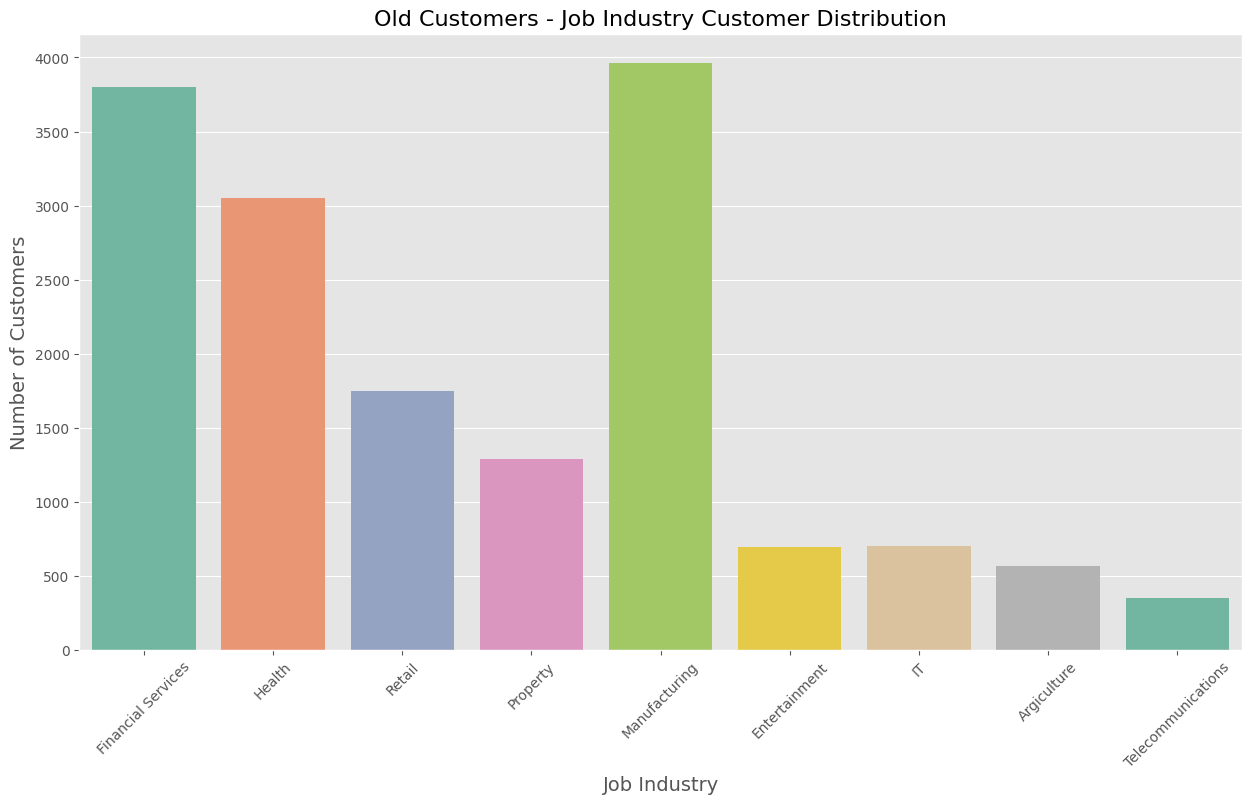

In [38]:
# Visualize the distribution of old customers by job industry, excluding missing entries
plt.figure(figsize=(15, 8))  # Set the figure size for the plot

# Create a count plot for job industry distribution, excluding 'Missing' entries
sns.countplot(x='job_industry_category', 
               data=cust_trans_rfm[~(cust_trans_rfm['job_industry_category'] == 'Missing')],
               palette='Set2')  # Using Set2 color palette for better visual appeal


plt.xlabel('Job Industry', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.title('Old Customers - Job Industry Customer Distribution', fontsize=16)
plt.xticks(rotation=45)  
plt.show() 


## 3.4 Wealth Segmentation by Age Group

Across all age groups, the largest number of customers are classified as 'Mass Customers', followed by 'High Net Worth' customers. However, among customers aged 40-49, 'Affluent Customers' outnumber 'High Net Worth' customers.

## New Customers

In [39]:
wealth_age_seg_new = new_cust.groupby(['wealth_segment', 'Age Group']).size().reset_index()

In [40]:
wealth_age_seg_new.rename(columns={0 : 'Number of Customers'}, inplace=True)

wealth_age_seg_new

,wealth_segment,Age Group,Number of Customers
0,Affluent Customer,20,3
1,Affluent Customer,30,49
2,Affluent Customer,40,15
3,Affluent Customer,50,58
4,Affluent Customer,60,40
5,Affluent Customer,70,41
6,Affluent Customer,80,20
7,Affluent Customer,90,9
8,High Net Worth,30,42
9,High Net Worth,40,34


C:\Users\thang\AppData\Local\Temp\ipykernel_20684\2138021156.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x='Age Group',


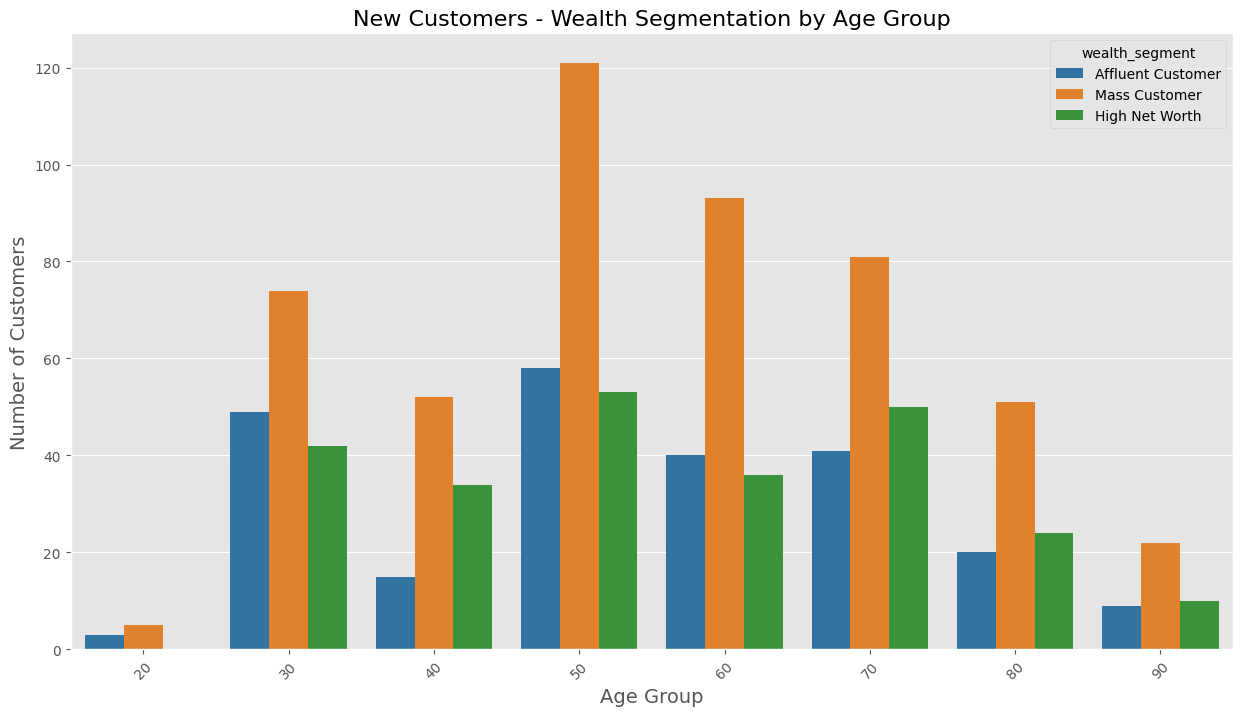

In [41]:
custom_dark_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
# Set the figure size for the plot
plt.figure(figsize=(15, 8))

# Create a bar plot for wealth segmentation by age group
sns.barplot(x='Age Group', 
            y='Number of Customers', 
            hue='wealth_segment', 
            data=wealth_age_seg_new, 
            palette=custom_dark_palette)  # Using Set2 color palette for better visual appeal

# Set the label for the x-axis
plt.xlabel('Age Group', fontsize=14)

# Set the label for the y-axis
plt.ylabel('Number of Customers', fontsize=14)

# Set the title for the plot
plt.title('New Customers - Wealth Segmentation by Age Group', fontsize=16)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()  # Show the final plot

In all age groups, the largest number of customers are classified as 'Mass Customers', followed by the 'High Net Worth' group as the second largest customer base. However, in the age group of 40-49, the 'Affluent Customers' outnumber the 'High Net Worth' group.



## Old Customers

Similar treand (like that of New Customers) is observed amoung Old Customers

In [42]:
wealth_age_seg_old = cust_trans_rfm.groupby(['wealth_segment', 'Age_Group']).size().reset_index()

In [43]:
wealth_age_seg_old.rename(columns={0 : 'Number of Customers'}, inplace=True)

wealth_age_seg_old

,wealth_segment,Age_Group,Number of Customers
0,Affluent Customer,30,682
1,Affluent Customer,40,857
2,Affluent Customer,50,1366
3,Affluent Customer,60,935
4,Affluent Customer,70,803
5,Affluent Customer,80,62
6,Affluent Customer,90,5
7,Affluent Customer,100,10
8,High Net Worth,30,535
9,High Net Worth,40,933


C:\Users\thang\AppData\Local\Temp\ipykernel_20684\2818868233.py:7: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x='Age_Group',


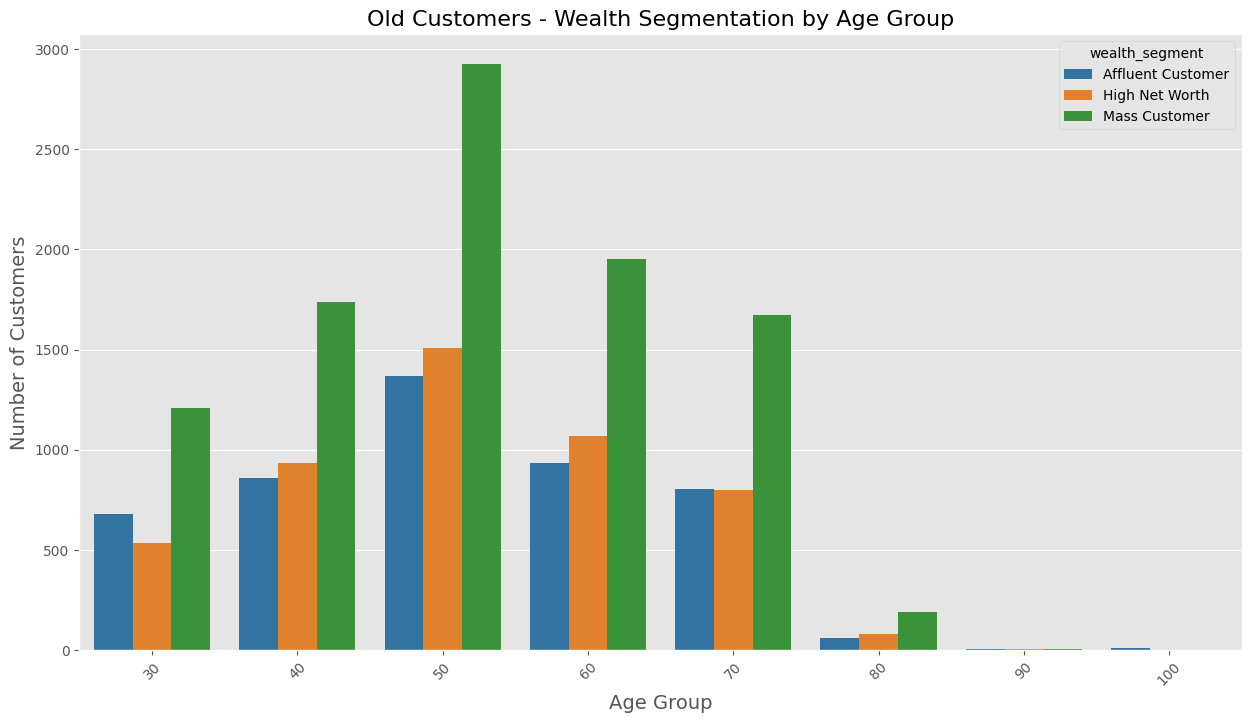

In [44]:
custom_dark_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Set the figure size for the plot
plt.figure(figsize=(15, 8))

# Create a bar plot for wealth segmentation by age group using a beautiful color palette
sns.barplot(x='Age_Group', 
            y='Number of Customers', 
            hue='wealth_segment', 
            data=wealth_age_seg_old, 
            palette=custom_dark_palette)  # Using the 'viridis' color palette for a beautiful gradient


plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.title('Old Customers - Wealth Segmentation by Age Group', fontsize=16)
plt.xticks(rotation=45)
plt.show() 

## 3.5 Car Ownership Across Each State

The customer base of the automobile and bike company is primarily located in New South Wales, Queensland, and Victoria, Australia. 

In New South Wales (NSW), there is a greater number of people who do not own a car. In Victoria (VIC), the proportion of car owners is evenly split. However, in Queensland (QLD), there are relatively more people who own a car.

In [45]:
# Loading the Customer Address Dataset
cust_addr_info = pd.read_csv('CustomerAddress_Cleaned.csv')


In [46]:
# Merging the RFM data with Customer Address dataset
cust_trans_addr = pd.merge(cust_trans_rfm, cust_addr_info, 
                           left_on='customer_id', 
                           right_on='customer_id', 
                           how='inner')


In [47]:
print("RFM table Records count : {}\nAddress Table Records count : {}".format(cust_trans_rfm.shape[0], cust_addr_info.shape[0]))


RFM table Records count : 19354
Address Table Records count : 3999


In [48]:
state_car_owners = cust_trans_addr[['state', 'owns_car', 'customer_id']].drop_duplicates() \
                            .groupby(['state', 'owns_car']).size().reset_index()


In [49]:
state_car_owners.rename(columns={0:'Number of Customers'}, inplace=True)
state_car_owners

,state,owns_car,Number of Customers
0,NSW,No,889
1,NSW,Yes,935
2,QLD,No,365
3,QLD,Yes,363
4,VIC,No,435
5,VIC,Yes,425


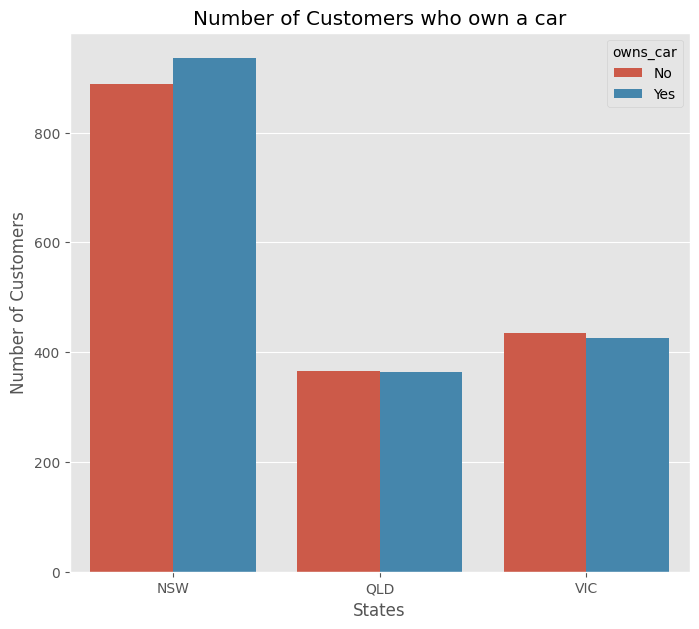

In [50]:
plt.figure(figsize=(8,7))
sns.barplot(x='state', y='Number of Customers' , hue='owns_car', data=state_car_owners)
plt.xlabel('States')
plt.ylabel('Number of Customers')
plt.title('Number of Customers who own a car')
plt.show()

New South Wales (NSW) has the largest number of people who do not own a car. It appears that more data has been collected from NSW compared to other states. In Queensland (QLD), the distribution between customers who own a car and those who do not is balanced. Similarly, in Victoria, car ownership is also evenly distributed. However, both states show significantly lower numbers of non-car owners compared to NSW.

## 4. RFM Analysis Scatter Plots

## 4.1. Recency vs Monetary

The chart reveals that customers who made purchases recently tend to generate higher revenue compared to those who made purchases a long time ago. Customers who purchased within the last 50-100 days contributed a moderate amount of revenue. On the other hand, customers who last visited around 200 days ago generated significantly lower revenue.

<Figure size 800x700 with 0 Axes>

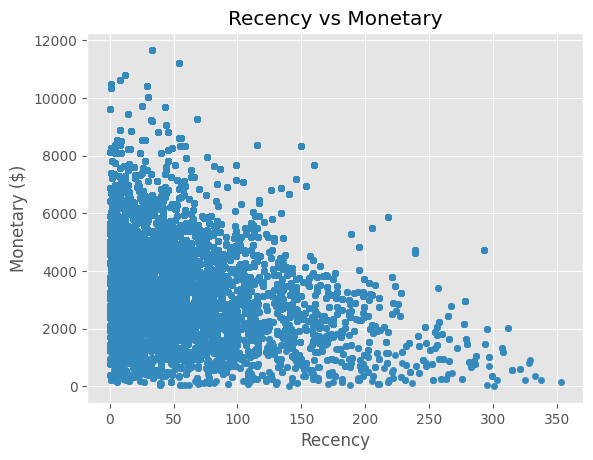

In [51]:
plt.figure(figsize=(8,7))
cust_trans_rfm.plot.scatter(x='recency' , y='monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary ($)')
plt.title('Recency vs Monetary')
plt.show()

## 4.2 Frequency vs Monetary

Customers classified as "Platinum Customers," "Very Loyal," and "Becoming Loyal" tend to visit frequently, and this frequency correlates with higher revenue for the business.

<Figure size 800x700 with 0 Axes>

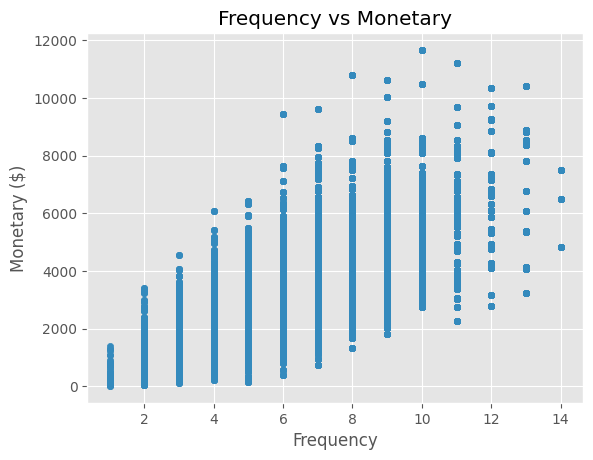

In [52]:
plt.figure(figsize=(8,7))
cust_trans_rfm.plot.scatter(x='frequency' , y='monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary ($)')
plt.title('Frequency vs Monetary')
plt.show()

In [ ]:
cust_trans_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19354 entries, 0 to 19353
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19354 non-null  int64         
 1   product_id                           19354 non-null  int64         
 2   customer_id                          19354 non-null  int64         
 3   transaction_date                     19354 non-null  datetime64[ns]
 4   online_order                         19354 non-null  object        
 5   order_status                         19354 non-null  object        
 6   brand                                19354 non-null  object        
 7   product_line                         19354 non-null  object        
 8   product_class                        19354 non-null  object        
 9   product_size                         19354 non-null  object        
 10  list_price

## 5. Customer Segment Distribution

Finally, we can visualize the number of customers in each customer segment by plotting their distribution across different segments.

In [66]:
cust_per_title = (cust_trans_rfm[['detail_cust_title', 'customer_id', 'customer_rank']]
                  .drop_duplicates()
                  .groupby(['detail_cust_title', 'customer_rank'])
                  .size()
                  .reset_index(name='count')
                  .sort_values(['customer_rank', 'detail_cust_title']))

In [67]:
cust_per_title.rename(columns={'count': 'Number of Customers'}, inplace=True)
cust_per_title

,detail_cust_title,customer_rank,Number of Customers
5,Platinum Customer,1,164
8,Very Loyal,2,285
1,Becoming Loyal,3,161
7,Recent Customer,4,198
6,Potential Customer,5,1161
3,Late Bloomer,6,115
0,Almost Lost Customer,9,88
2,Evasive Customer,10,538
4,Lost Customer,11,706


C:\Users\thang\AppData\Local\Temp\ipykernel_20684\2527648688.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='detail_cust_title',


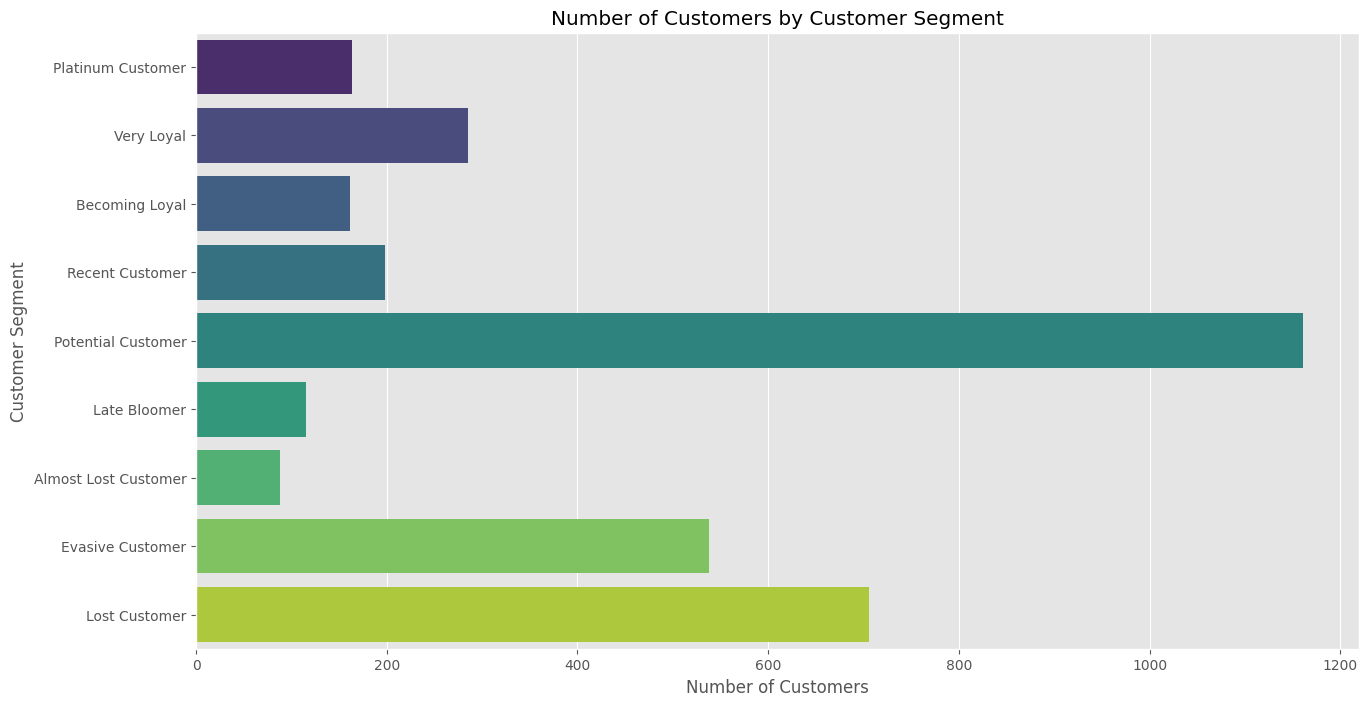

In [68]:
plt.figure(figsize=(15,8))
sns.barplot(y='detail_cust_title', 
            x='Number of Customers', 
            data=cust_per_title, 
            palette='viridis')  # You can change 'viridis' to other palettes like 'Blues', 'coolwarm', etc.
plt.xlabel('Number of Customers')
plt.ylabel('Customer Segment')
plt.title('Number of Customers by Customer Segment')
plt.show()
